# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [23]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gym
from gym.wrappers import Monitor

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

In [24]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
torch.__version__ = 1.9.1+cu102
np.__version__ = 1.21.2
gym.__version__ = 0.20.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [25]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[-0.5555, -0.7877],
        [-1.3883,  1.1399],
        [-0.2611, -0.3072]]) 
+
 tensor([[ 0.8411, -0.4659],
        [ 0.7858,  2.1345],
        [ 1.3807, -0.9086]]) 
=
 tensor([[ 0.2857, -1.2536],
        [-0.6025,  3.2744],
        [ 1.1195, -1.2158]])


### Gradient management

In [26]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([2.0302])
Final estimate: tensor([1.9999])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [27]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1

### 2 - Replay buffer

In [28]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 3 - Neural Network

In [29]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [30]:
# create network and target network
hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

## Implementing the DQN

In [31]:
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor([states])
        output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

#### Question 1

Implement the `choose_action` function.

In [32]:
def choose_action(state, epsilon):
    """
    ** TO BE IMPLEMENTED **
    
    Return action according to an epsilon-greedy exploration policy
    """
    return 0

#### Question 2

Implement the `eval_dqn` function.

In [33]:
def eval_dqn(n_sim=5):
    """
    ** TO BE IMPLEMENTED **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    
    
    return episode_rewards

#### Question 3

Implement the `update` function

In [34]:
def update(state, action, reward, next_state, done):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)
    
    # Compute loss - TO BE IMPLEMENTED!
    values  = torch.zeros(BATCH_SIZE)   # to be computed using batch
    targets = torch.zeros(BATCH_SIZE)   # to be computed using batch
    loss = objective(values, targets)
     
    # Optimize the model - UNCOMMENT!
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
    return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

In [35]:
EVAL_EVERY = 5
REWARD_THRESHOLD = 199

def train():
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                print("episode =", ep+1, ", reward = ", np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1

# Run the training loop
train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))

episode = 5 , reward =  0.0
episode = 10 , reward =  0.0
episode = 15 , reward =  0.0
episode = 20 , reward =  0.0
episode = 25 , reward =  0.0
episode = 30 , reward =  0.0
episode = 35 , reward =  0.0
episode = 40 , reward =  0.0
episode = 45 , reward =  0.0
episode = 50 , reward =  0.0
episode = 55 , reward =  0.0
episode = 60 , reward =  0.0
episode = 65 , reward =  0.0
episode = 70 , reward =  0.0
episode = 75 , reward =  0.0
episode = 80 , reward =  0.0
episode = 85 , reward =  0.0
episode = 90 , reward =  0.0
episode = 95 , reward =  0.0
episode = 100 , reward =  0.0
episode = 105 , reward =  0.0
episode = 110 , reward =  0.0
episode = 115 , reward =  0.0
episode = 120 , reward =  0.0
episode = 125 , reward =  0.0
episode = 130 , reward =  0.0
episode = 135 , reward =  0.0
episode = 140 , reward =  0.0
episode = 145 , reward =  0.0
episode = 150 , reward =  0.0
episode = 155 , reward =  0.0
episode = 160 , reward =  0.0
episode = 165 , reward =  0.0
episode = 170 , reward =  0.0


#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

In [36]:
def show_video():
    html = []
    for mp4 in Path("videos").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()
# show_video()

/home/akaen/.local/lib/python3.8/site-packages/gym/wrappers/monitor.py:31: UserWarning: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  warnings.warn(


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

### Experiments: Do It Yourself

Remember the set of global parameters:
```
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1
```

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.
![Phase diagram](phase_plot.png)

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -199.84
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -195.07
Episode 600 Average Reward: -195.59
Episode 700 Average Reward: -194.54
Episode 800 Average Reward: -186.05
Episode 900 Average Reward: -183.3
Episode 1000 Average Reward: -191.79
Episode 1100 Average Reward: -197.1
Episode 1200 Average Reward: -190.64
Episode 1300 Average Reward: -179.56
Episode 1400 Average Reward: -183.02
Episode 1500 Average Reward: -168.91
Episode 1600 Average Reward: -165.02
Episode 1700 Average Reward: -168.17
Episode 1800 Average Reward: -161.04
Episode 1900 Average Reward: -170.95
Episode 2000 Average Reward: -159.91
Episode 2100 Average Reward: -161.02
Episode 2200 Average Reward: -158.5
Episode 2300 Average Reward: -159.1
Episode 2400 Average Reward: -160.04
Episode 2500 Average Reward: -158.97
Episode 2600 Average Reward: -159.13
Episode 2700 Average Reward: -156.55
Episode 2800 Aver

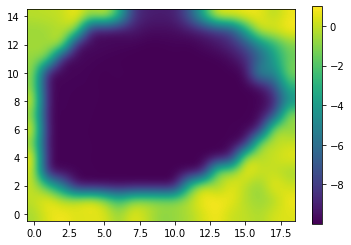

In [216]:
# TODO: Everything! This is an introduction to research and development

import numpy as np
import gym
import matplotlib.pyplot as plt

env = gym.make('MountainCar-v0')
env.reset()

def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)* np.array([10,100])
    num_states = np.round(num_states, 0).astype(int) +1


    # instead of initialising the Q table with
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    reduction = 0.99
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)+1
    
        while done != True:   
                
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            state2, reward, done, info = env.step(action) 
            
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int) +1

            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            else:
                old_value = Q[state_adj[0],state_adj[1],action]
                next_max = np.max(Q[state2_adj[0], state2_adj[1]]) 
                new_value = old_value + learning * (reward + 0.9 * next_max - old_value)
                Q[state_adj[0], state_adj[1],action] = new_value
                                     
            tot_reward += reward
            state_adj = state2_adj
        
        if epsilon > min_eps:
            epsilon *= reduction
        
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    
    return ave_reward_list,Q

# Run Q-learning algorithm

rewards,Q = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)
plt.imshow(Q.T[1], interpolation="bicubic",origin='lower')
plt.colorbar()
plt.show()

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards.jpg')     
plt.close()  
  


In [210]:
l_x=[]
l_y=[]
l_z=[]

for i,x in enumerate(Q):
    for j,y in enumerate(x):
        state_cont = np.divide(np.array([i,j]),np.array([10, 100]) )+ env.observation_space.low
        l_x.append(state_cont[0])
        l_y.append(state_cont[1])
        l_z += [np.max(x[j])]
        
x = np.array(l_x)
y = np.array(l_y)
z = np.array(l_z)
q = np.array([x,y,z])

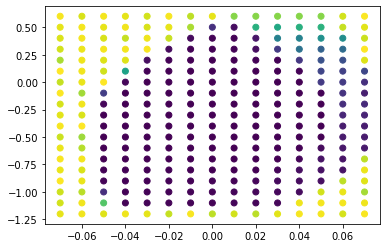

In [213]:
plt.scatter(y,x,c=z)

## Bonus: SAIL-DQN


In this section, we will add the SAIL bonus to DQN.

SAIL (from [*Self-Imitation Advantage Learning*](https://arxiv.org/abs/2012.11989) [Ferret et al., 2020]) modifies DQN to add a self-imitation bonus. Self-imitation consists in reproducing actions that performed better than expected, *i.e.* better than the current value estimate. It is especially useful in tasks with sparse rewards, where at first it is uncommon to get positive rewards due to the initially random exploration of the agent. With self-imitation, the agent has incentive to reproduce actions that led to these uncommon rewards.

An important quantity for SAIL is the **return** $G_t$, or the cumulative sum of rewards to-go. It corresponds to the *observed* discounted sum of rewards starting from state $s_t$:

$$G_t = \sum_{t'=t}^T \gamma^{t' - t} r(s_{t'}, a_{t'}).$$

Since we need that quantity to compute the SAIL bonus, we will need to observe full episodes before saving them to the replay buffer.

Then, SAIL modifies the Q-learning update as follows:

$$
y_{i, SAIL} = r_{i, SAIL} + \gamma \max_{a'} Q(s_i', a', \theta^-),
$$
where
$$
r_{i, SAIL} = r_i + \alpha \Big(\max\{G_i, Q(s_i, a_i, \theta^-)\} - \max_{a'} Q(s_i, a', \theta^-)\Big).
$$

Let us break down this modification, which can be seen as adding a bonus to the reward. 

The term $\max\{G_i, Q(s_i, a_i, \theta^-)\}$ is the maximum of two return estimates: $G_i$ is the Monte Carlo return estimate (*i.e.* obtained via simulation) and $Q(s_i, a_i, \theta^-)$ is the agent's return estimate (*i.e.* estimated from previous experience). Hence, this first term is an optimistic estimate of the return.

The term $\max_{a'} Q(s_i, a', \theta^-)$ is a value estimate. Instead of using the observed action (*i.e.* the one actually taken by the agent), it uses the most probable action (which is the argmax).

Subtracting these two terms give an optimistic version of the advantage $A_i = G_i - \max_{a'} Q(s_i, a', \theta^-)$. The advantage roughly measures how much we gain by taking an action that differs from the one we usually take. Using it as a bonus encourages actions that lead to better results than currently expected. 

SAIL modifies DQN as follows:

1.   Transitions should now store the observed return $G_i$ as well. $G_i$ is unknown until the end of the episode is reached. So, at each time $t$, the agent has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **temporary replay buffer**.

2.   Take actions as in DQN and observe rewards and next states.

3.   When the end of the episode is reached, returns $(G_i)_{i=0}^T$ are calculated. Returns are added to the transitions. All transitions are added to the **replay buffer**, which now stores returns as well.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_{i, SAIL}
\right]^2
$$

5. Do the rest as in DQN.





`choose_action`, `get_q` and `eval_dqn` remain the same.

To be implemented:
* `update_sail`, compared to `update`, modifies $y_i$ as explained above.
* `train_sail` adds several steps to `train`. 

Tip #1: `replay_buffer` now contains returns as well.

Tip #2: in the computed advantage, use $Q(s_i, a_i, \theta^-)$, not $Q(s_i, a_i)$. It makes the bonus more stable.

Tip #3: `torch.maximum` can be used to compute the element-wise max between two arrays.

#### Question 9

Implement `update_sail` function.

In [ ]:
 def update_sail(state, action, reward, next_state, done):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to temporary replay buffer
    if done:
        next_state = None
    replay_buffer_temp.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)

    # Compute loss - TO BE IMPLEMENTED!
    values  = torch.zeros(BATCH_SIZE)   # to be computed using batch
    targets = torch.zeros(BATCH_SIZE)   # to be computed using batch
    loss = objective(values, targets)
     
    # Optimize the model - UNCOMMENT!
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
    return loss.detach().numpy()

#### Question 10

Implement the training loop.

In [ ]:
def get_episode_returns(rewards):
    returns_reversed = accumulate(rewards[::-1],
                                lambda x, y: x*GAMMA + y)
    return list(returns_reversed)[::-1]

def train_sail():
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update_sail(state, action, reward, next_state, done)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                print("episode =", ep+1, ", reward = ", np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # fetch transitions from the temporary memory
            transitions = replay_buffer_temp.memory

            # calculate episode returns
            # TO IMPLEMENT

            # transfer transitions completed with returns to main memory
            # TO IMPLEMENT

            # reset the temporary memory
            # TO IMPLEMENT

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1

# Run the training loop
train_sail()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))

#### Question 11

Display your policy in action.

In [ ]:
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

def show_video():
    html = []
    for mp4 in Path("videos").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()
# show_video()